In [26]:
import sys


import numpy as np
import h5py
import Analysis
from copy import deepcopy

def AddFitMetadata(path, h5_path, A, extra_dict=None):
        h5 = h5py.File(path)
        
        try: 
            h5.create_group(h5_path)
        except:
            del h5[h5_path]
            h5.create_group(h5_path)
            

        fa = h5[h5_path].attrs
        fit = A.SaveFit()

        for key, val in fit.items():
            if key not in ['Data', 'energies', 'loglike', 'PSC']:
                fa.create('flux_'+key,val['flux'])
                fa.create('fluxunc_'+key,val['fluxunc'])        

        fa.create('loglike_total',np.sum(A.loglike))
        fa.create('loglike',A.loglike)
        fa.create('energies',A.central_energies)
        fa.create('bins', A.bin_edges)
        fa.create('irf', A.irf)
        fa.create('evclass', A.evclass)
        fa.create('convtype', A.convtype)
        fa.create('phfile', A.phfile)
        fa.create('tag', A.tag)

        if extra_dict is not None:
            for key, val in extra_dict.items():
                if key == 'residual':
                    try:
                        del h5[h5_path+'/residual']
                    except: 
                        pass

                    h5.create_dataset(h5_path+'/residual', data=val, dtype='float32')
                    print 'Saving new residual... Shape = ', val.shape
                else:
                    fa.create(key, val)
        h5.close()

def LoadModel(basedir, galprop_tag):
    # Load various diffuse models and run fits.
    print 'Running Analysis for model', galprop_tag
    
    
    A = Analysis.Analysis(tag='P8R2_PSF3_CLEAN_V6_calore', basepath='/data/GCE_sys/')
    #A = Analysis.Analysis(tag='P8R2_CLEAN_V6_calore', basepath='/data/GCE_sys/')
    
    
    A.GenSquareMask(l_range=[-7.5,7.5], b_range=[-7.5,7.5], plane_mask=2.)
    A.BinPhotons(infile='binned_photons_'+A.tag+'.npy')
    # Load 2FGL 
    A.AddPointSourceTemplate(fixNorm=True,pscmap='PSC_' + A.tag + '_fgl3_with_ext.npy')
    A.CalculatePixelWeights(diffuse_model='fermi_diffuse_'+A.tag+'.npy',psc_model='PSC_' + A.tag + '_fgl3_with_ext.npy',
                        alpha_psc=5., f_psc=0.1)
    A.AddIsotropicTemplate(fixNorm=False, fixSpectrum=False) # External chi^2 used to fix normalization within uncertainties
    
    A.AddFermiBubbleTemplate(template_file='./bubble_templates_diskcut30.0.fits', 
                         spec_file='./reduced_bubble_spec_apj_793_64.dat', fixSpectrum=False, fixNorm=False)
    
    
    A.AddHDF5Template(hdf5file=basedir +'/'+ galprop_tag+'.hdf5',verbosity=1, multiplier=2., bremsfrac=1.25, 
                  E_subsample=2, fixSpectrum=False, separate_ics=False)
    return A



In [27]:
A = LoadModel('/data/GCE_sys/new','mod_s_42_XCO_P8')
A2 = LoadModel('/data/GCE_sys/new','mod_s_46_XCO_P8')
#/data/GCE_sys/new/mod_s_44_XCO_P8.hdf5

Running Analysis for model mod_s_42_XCO_P8
Loading HDF5 file
Integrating and Resampling ics templates...
Integrating and Resampling pi0 templates...
Integrating and Resampling brem templates...
Running Analysis for model mod_s_46_XCO_P8
Loading HDF5 file
Integrating and Resampling ics templates...
Integrating and Resampling pi0 templates...
Integrating and Resampling brem templates...


Analysis.py:1378: RuntimeWarning: divide by zero encountered in divide
  self.psc_weights = 1./((psc/(f_psc*diff_model))**alpha_psc+1)


In [28]:
A.AddDMTemplate(profile='NFW', limits=[None,None], decay=False, gamma=1.25, 
               r_s=20.0, axesratio=1., offset=(0., 0.), spec_file=None,)
A2.AddDMTemplate(profile='NFW', limits=[None,None], decay=False, gamma=1.25, 
               r_s=20.0, axesratio=1., offset=(0., 0.), spec_file=None,)

array([  3.13970399e-15,   0.00000000e+00,   0.00000000e+00, ...,
         0.00000000e+00,   0.00000000e+00,   3.13970399e-15])

In [29]:
A.ResetFit()    
%load_ext autoreload
%autoreload 2
for key, template in A.templateList.items():
    if key != 'DM':
        template.limits=[0,None]
        
    if key == 'DM':
        template.limits=[0,None]

for key, template in A2.templateList.items():
    if key != 'DM':
        template.limits=[0,None]
        
    if key == 'DM':
        template.limits=[0,None]

A.RunLikelihood(print_level=1, tol=2e2, precision=None, minos=False, statistic='Poisson')[0]
A2.RunLikelihood(print_level=1, tol=2e2, precision=None, minos=False)[0]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Masking completed in 1.5544e-01 s
Write likelihood tempfile to  /tmp/tmpVvWpc7
Code generation completed in 3.7010e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -13780.5241276 
 TOTAL NCALL = 207 
 NCALLS = 207 
 
 
 EDM = 0.00171222497649 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_0,5.823545e-02,9.133302e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_0,9.807642e-01,3.861727e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_0,1.166723e+00,2.930779e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_0,7.799448e-01,1.048094e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_0,1.483402e+00,3.639989e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   1.56e-01 s
Masking completed in 1.8060e-01 s
Write likelihood tempfile to  /tmp/tmpXRg9Yt
Code generation completed in 2.5249e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -10501.6627764 
 TOTAL NCALL = 171 
 NCALLS = 171 
 
 
 EDM = 0.000384642489203 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_1,1.671057e-01,9.312412e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_1,9.888770e-01,4.098744e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_1,1.004262e+00,2.710860e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_1,7.457837e-01,9.688734e-02,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_1,9.687866e-01,3.425657e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   3.36e-02 s
Masking completed in 1.3234e-01 s
Write likelihood tempfile to  /tmp/tmpV9_ZXd
Code generation completed in 2.4660e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -7828.93225367 
 TOTAL NCALL = 165 
 NCALLS = 165 
 
 
 EDM = 0.00058476211694 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_2,1.568572e-01,1.000553e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_2,1.017343e+00,4.540019e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_2,1.051206e+00,2.448546e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_2,8.409704e-01,1.038356e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_2,1.113765e+00,3.294051e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   3.00e-02 s
Masking completed in 1.3166e-01 s
Write likelihood tempfile to  /tmp/tmp9W6kFA
Code generation completed in 2.4500e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -5309.69882527 
 TOTAL NCALL = 148 
 NCALLS = 148 
 
 
 EDM = 0.00102139776856 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_3,2.435601e-01,9.824093e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_3,9.612720e-01,4.897757e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_3,1.052839e+00,2.215823e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_3,8.708923e-01,1.090948e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_3,1.166767e+00,3.106484e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.74e-02 s
Masking completed in 1.3172e-01 s
Write likelihood tempfile to  /tmp/tmpltoiOR
Code generation completed in 2.4099e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -5075.00275862 
 TOTAL NCALL = 122 
 NCALLS = 122 
 
 
 EDM = 4.21812289165e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_4,4.821760e-01,1.059913e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_4,9.419907e-01,4.888086e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_4,9.995942e-01,1.868600e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_4,7.527883e-01,1.077567e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_4,1.021676e+00,2.960517e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.86e-02 s
Masking completed in 1.3154e-01 s
Write likelihood tempfile to  /tmp/tmpiOYjH8
Code generation completed in 1.0831e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -5344.5566902 
 TOTAL NCALL = 134 
 NCALLS = 134 
 
 
 EDM = 0.00488004931047 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_5,3.063870e-01,7.079924e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_5,1.070346e+00,4.952668e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_5,1.030072e+00,1.547530e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_5,6.812812e-01,1.065473e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_5,1.062545e+00,2.832265e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.50e-02 s
Masking completed in 1.3165e-01 s
Write likelihood tempfile to  /tmp/tmpXgMsPd
Code generation completed in 2.4471e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -4986.78833906 
 TOTAL NCALL = 136 
 NCALLS = 136 
 
 
 EDM = 0.00168281049385 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_6,2.603557e-01,7.799053e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_6,1.060941e+00,4.874700e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_6,1.014653e+00,1.283196e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_6,7.358018e-01,1.017021e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_6,1.100260e+00,2.639195e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.52e-02 s
Masking completed in 1.3185e-01 s
Write likelihood tempfile to  /tmp/tmpjr0rZD
Code generation completed in 2.4612e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -4573.11367281 
 TOTAL NCALL = 136 
 NCALLS = 136 
 
 
 EDM = 0.000345856693038 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_7,3.273192e-01,6.381601e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_7,9.944204e-01,5.082921e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_7,1.020770e+00,1.201890e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_7,8.194908e-01,1.077687e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_7,1.215330e+00,2.576409e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.52e-02 s
Masking completed in 1.3134e-01 s
Write likelihood tempfile to  /tmp/tmpCiuaBU
Code generation completed in 2.4040e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -4079.27233203 
 TOTAL NCALL = 162 
 NCALLS = 162 
 
 
 EDM = 0.000139617057787 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_8,1.573128e-01,6.332349e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_8,9.532707e-01,5.082962e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_8,1.007561e+00,1.163581e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_8,1.091039e+00,1.050348e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_8,1.043095e+00,2.542970e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.96e-02 s
Masking completed in 1.3121e-01 s
Write likelihood tempfile to  /tmp/tmpk8E0Ji
Code generation completed in 1.0591e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -3276.22731919 
 TOTAL NCALL = 122 
 NCALLS = 122 
 
 
 EDM = 3.49240485096e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_9,2.911877e-01,5.909002e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_9,1.066104e+00,5.248210e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_9,1.006498e+00,1.140960e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_9,7.324024e-01,1.086220e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_9,1.157087e+00,2.542547e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.31e-02 s
Masking completed in 1.3134e-01 s
Write likelihood tempfile to  /tmp/tmpqH81jw
Code generation completed in 2.5861e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -2545.99013408 
 TOTAL NCALL = 136 
 NCALLS = 136 
 
 
 EDM = 0.00202559199401 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_10,2.335289e-01,4.566043e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_10,1.014178e+00,5.333548e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_10,1.001152e+00,1.168055e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_10,8.166333e-01,1.065017e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_10,1.085581e+00,2.697835e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.52e-02 s
Masking completed in 1.3196e-01 s
Write likelihood tempfile to  /tmp/tmp4pqvXy
Code generation completed in 2.4271e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -1471.34754775 
 TOTAL NCALL = 150 
 NCALLS = 150 
 
 
 EDM = 0.0015267590725 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_11,1.752831e-01,4.354841e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_11,9.898102e-01,5.813185e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_11,9.997317e-01,1.203595e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_11,1.019408e+00,1.142323e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_11,9.986380e-01,2.999499e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.71e-02 s
Masking completed in 1.3118e-01 s
Write likelihood tempfile to  /tmp/tmpVoCdqS
Code generation completed in 1.0910e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -396.842350589 
 TOTAL NCALL = 123 
 NCALLS = 123 
 
 
 EDM = 0.00254529963285 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_12,2.835076e-01,4.570886e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_12,1.076856e+00,6.092192e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_12,1.000052e+00,1.274210e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_12,6.445673e-01,1.153438e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_12,9.898283e-01,2.968381e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.29e-02 s
Masking completed in 1.3130e-01 s
Write likelihood tempfile to  /tmp/tmp30ZRH9
Code generation completed in 2.4309e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 635.441654154 
 TOTAL NCALL = 134 
 NCALLS = 134 
 
 
 EDM = 1.77841565334e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_13,2.711394e-01,4.146256e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_13,1.085417e+00,6.528973e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_13,1.000572e+00,1.323027e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_13,5.309191e-01,1.158237e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_13,1.080940e+00,2.794290e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.48e-02 s
Masking completed in 1.3114e-01 s
Write likelihood tempfile to  /tmp/tmpN88etr
Code generation completed in 4.0951e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 1449.85051162 
 TOTAL NCALL = 148 
 NCALLS = 148 
 
 
 EDM = 0.000426635310609 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_14,1.848360e-01,4.487854e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_14,1.019989e+00,7.263108e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_14,1.002671e+00,1.167796e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_14,9.367393e-01,1.229580e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_14,9.839755e-01,2.515208e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   6.98e-02 s
Masking completed in 1.8064e-01 s
Write likelihood tempfile to  /tmp/tmp3sU7C2
Code generation completed in 1.0910e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 2041.35342938 
 TOTAL NCALL = 121 
 NCALLS = 121 
 
 
 EDM = 7.26023894475e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_15,2.539358e-01,4.311984e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_15,1.090987e+00,8.651197e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_15,9.986619e-01,1.111908e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_15,7.859504e-01,1.379260e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_15,9.910397e-01,2.284803e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.42e-02 s
Masking completed in 1.3851e-01 s
Write likelihood tempfile to  /tmp/tmpzyopZg
Code generation completed in 3.2060e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 2562.72702743 
 TOTAL NCALL = 123 
 NCALLS = 123 
 
 
 EDM = 0.00544208454213 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_16,1.678993e-01,4.235244e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_16,1.268233e+00,1.025597e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_16,1.001851e+00,1.287606e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_16,7.313738e-01,1.489970e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_16,9.391173e-01,2.687549e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.40e-02 s
Masking completed in 1.4092e-01 s
Write likelihood tempfile to  /tmp/tmpBGbykK
Code generation completed in 2.5418e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 2778.58668051 
 TOTAL NCALL = 113 
 NCALLS = 113 
 
 
 EDM = 0.00916685073086 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_17,2.935914e-01,5.112976e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_17,1.095748e+00,1.225462e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_17,1.006479e+00,1.534994e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_17,6.476979e-01,1.630866e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_17,1.078908e+00,2.620880e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.18e-02 s
Masking completed in 1.3297e-01 s
Write likelihood tempfile to  /tmp/tmpyoJ52P
Code generation completed in 1.1160e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 2647.40973268 
 TOTAL NCALL = 123 
 NCALLS = 123 
 
 
 EDM = 0.00139128312892 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_18,1.647214e-01,7.198759e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_18,1.362493e+00,1.560314e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_18,1.000433e+00,1.561146e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_18,7.221278e-01,1.849950e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_18,9.669370e-01,1.966870e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.36e-02 s
Masking completed in 1.3326e-01 s
Write likelihood tempfile to  /tmp/tmpLDOoaL
Code generation completed in 1.1041e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 2280.37919745 
 TOTAL NCALL = 132 
 NCALLS = 132 
 
 
 EDM = 0.00376671844174 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_19,1.321997e-01,6.432353e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_19,1.551186e+00,2.006542e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_19,1.001369e+00,1.362336e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_19,5.197609e-01,2.024104e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_19,1.018302e+00,1.535912e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.51e-02 s
Masking completed in 1.3325e-01 s
Write likelihood tempfile to  /tmp/tmpZHOXYw
Code generation completed in 1.1010e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 1766.39207803 
 TOTAL NCALL = 140 
 NCALLS = 140 
 
 
 EDM = 1.15597709378e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_20,4.967075e-02,1.111096e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_20,1.191052e+00,2.817780e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_20,1.000505e+00,1.300223e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_20,1.002768e+00,2.655448e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_20,9.875359e-01,1.395399e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.66e-02 s
Masking completed in 1.3263e-01 s
Write likelihood tempfile to  /tmp/tmpIzOFrP
Code generation completed in 1.1158e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 1287.19293679 
 TOTAL NCALL = 165 
 NCALLS = 165 
 
 
 EDM = 0.00802972993655 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_21,2.922198e-01,1.054823e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_21,2.017978e+00,3.222945e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_21,9.987399e-01,1.219644e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_21,7.340305e-03,4.043303e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_21,9.774878e-01,1.245415e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   3.02e-02 s
Masking completed in 1.3272e-01 s
Write likelihood tempfile to  /tmp/tmp_a1IK4
Code generation completed in 5.4910e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 801.964083123 
 TOTAL NCALL = 145 
 NCALLS = 145 
 
 
 EDM = 0.000228344479771 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_22,1.203142e-01,1.496582e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_22,2.621960e+00,8.521086e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_22,9.986391e-01,1.255712e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_22,4.816050e-01,5.905055e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_22,9.912067e-01,1.072732e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.71e-02 s
Masking completed in 1.3248e-01 s
Write likelihood tempfile to  /tmp/tmpbVf4kw
Code generation completed in 1.0860e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 289.986450556 
 TOTAL NCALL = 117 
 NCALLS = 117 
 
 
 EDM = 0.00141048491326 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_23,7.743962e-01,4.295660e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_23,8.260709e-03,1.794033e+00,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_23,9.987384e-01,2.217526e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_23,1.201283e+00,1.288651e+00,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_23,9.964658e-01,1.568555e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.23e-02 s


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_0,5.823545e-02,9.032906e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_0,9.807642e-01,3.861688e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_0,1.166723e+00,2.930743e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_0,7.799448e-01,1.039828e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_0,1.483402e+00,3.640019e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_0,Pi0_Brems_0,Isotropic_0,ICS_0,Bubbles_0
DM_0,1.00,-0.01,0.03,-0.79,0.04
Pi0_Brems_0,-0.01,1.00,0.11,-0.51,0.07
Isotropic_0,0.03,0.11,1.00,-0.30,-0.04
ICS_0,-0.79,-0.51,-0.30,1.00,-0.18
Bubbles_0,0.04,0.07,-0.04,-0.18,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_1,1.671057e-01,9.316812e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_1,9.888770e-01,4.098773e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_1,1.004262e+00,2.710866e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_1,7.457837e-01,9.691623e-02,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_1,9.687866e-01,3.425876e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_1,Pi0_Brems_1,Isotropic_1,ICS_1,Bubbles_1
DM_1,1.00,-0.05,0.02,-0.73,0.04
Pi0_Brems_1,-0.05,1.00,0.09,-0.55,0.06
Isotropic_1,0.02,0.09,1.00,-0.29,-0.03
ICS_1,-0.73,-0.55,-0.29,1.00,-0.18
Bubbles_1,0.04,0.06,-0.03,-0.18,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_2,1.568572e-01,1.001112e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_2,1.017343e+00,4.540053e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_2,1.051206e+00,2.448722e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_2,8.409704e-01,1.038701e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_2,1.113765e+00,3.294139e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_2,Pi0_Brems_2,Isotropic_2,ICS_2,Bubbles_2
DM_2,1.00,-0.07,0.02,-0.71,0.05
Pi0_Brems_2,-0.07,1.00,0.07,-0.57,0.04
Isotropic_2,0.02,0.07,1.00,-0.25,-0.03
ICS_2,-0.71,-0.57,-0.25,1.00,-0.18
Bubbles_2,0.05,0.04,-0.03,-0.18,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_3,2.435601e-01,9.823907e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_3,9.612720e-01,4.897763e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_3,1.052839e+00,2.215885e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_3,8.708923e-01,1.090940e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_3,1.166767e+00,3.106515e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_3,Pi0_Brems_3,Isotropic_3,ICS_3,Bubbles_3
DM_3,1.00,-0.10,0.02,-0.69,0.04
Pi0_Brems_3,-0.10,1.00,0.06,-0.57,0.03
Isotropic_3,0.02,0.06,1.00,-0.21,-0.02
ICS_3,-0.69,-0.57,-0.21,1.00,-0.16
Bubbles_3,0.04,0.03,-0.02,-0.16,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_4,4.821760e-01,1.062553e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_4,9.419907e-01,4.876138e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_4,9.995942e-01,1.872983e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_4,7.527883e-01,1.068128e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_4,1.021676e+00,2.965754e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_4,Pi0_Brems_4,Isotropic_4,ICS_4,Bubbles_4
DM_4,1.00,-0.10,0.02,-0.68,0.04
Pi0_Brems_4,-0.10,1.00,0.05,-0.59,0.03
Isotropic_4,0.02,0.05,1.00,-0.18,-0.02
ICS_4,-0.68,-0.59,-0.18,1.00,-0.16
Bubbles_4,0.04,0.03,-0.02,-0.16,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_5,3.063870e-01,7.080104e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_5,1.070346e+00,4.952709e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_5,1.030072e+00,1.547541e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_5,6.812812e-01,1.065511e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_5,1.062545e+00,2.832299e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_5,Pi0_Brems_5,Isotropic_5,ICS_5,Bubbles_5
DM_5,1.00,-0.12,0.01,-0.66,0.05
Pi0_Brems_5,-0.12,1.00,0.04,-0.59,0.03
Isotropic_5,0.01,0.04,1.00,-0.16,-0.02
ICS_5,-0.66,-0.59,-0.16,1.00,-0.17
Bubbles_5,0.05,0.03,-0.02,-0.17,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_6,2.603557e-01,7.799552e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_6,1.060941e+00,4.874736e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_6,1.014653e+00,1.283201e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_6,7.358018e-01,1.017070e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_6,1.100260e+00,2.639217e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_6,Pi0_Brems_6,Isotropic_6,ICS_6,Bubbles_6
DM_6,1.00,-0.15,0.01,-0.62,0.05
Pi0_Brems_6,-0.15,1.00,0.04,-0.61,0.03
Isotropic_6,0.01,0.04,1.00,-0.14,-0.01
ICS_6,-0.62,-0.61,-0.14,1.00,-0.17
Bubbles_6,0.05,0.03,-0.01,-0.17,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_7,3.273192e-01,6.381671e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_7,9.944204e-01,5.082923e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_7,1.020770e+00,1.201893e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_7,8.194908e-01,1.077706e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_7,1.215330e+00,2.576423e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_7,Pi0_Brems_7,Isotropic_7,ICS_7,Bubbles_7
DM_7,1.00,-0.15,0.01,-0.61,0.05
Pi0_Brems_7,-0.15,1.00,0.03,-0.62,0.02
Isotropic_7,0.01,0.03,1.00,-0.12,-0.01
ICS_7,-0.61,-0.62,-0.12,1.00,-0.17
Bubbles_7,0.05,0.02,-0.01,-0.17,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_8,1.573128e-01,6.331637e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_8,9.532707e-01,5.082929e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_8,1.007561e+00,1.163582e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_8,1.091039e+00,1.050300e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_8,1.043095e+00,2.542986e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_8,Pi0_Brems_8,Isotropic_8,ICS_8,Bubbles_8
DM_8,1.00,-0.18,0.01,-0.58,0.05
Pi0_Brems_8,-0.18,1.00,0.03,-0.63,0.02
Isotropic_8,0.01,0.03,1.00,-0.11,-0.01
ICS_8,-0.58,-0.63,-0.11,1.00,-0.17
Bubbles_8,0.05,0.02,-0.01,-0.17,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_9,2.911877e-01,5.977165e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_9,1.066104e+00,5.248514e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_9,1.006498e+00,1.141835e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_9,7.324024e-01,1.077515e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_9,1.157087e+00,2.546082e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_9,Pi0_Brems_9,Isotropic_9,ICS_9,Bubbles_9
DM_9,1.00,-0.18,0.01,-0.58,0.06
Pi0_Brems_9,-0.18,1.00,0.02,-0.64,0.02
Isotropic_9,0.01,0.02,1.00,-0.11,-0.01
ICS_9,-0.58,-0.64,-0.11,1.00,-0.17
Bubbles_9,0.06,0.02,-0.01,-0.17,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_10,2.335289e-01,4.566134e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_10,1.014178e+00,5.333586e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_10,1.001152e+00,1.168056e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_10,8.166333e-01,1.065050e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_10,1.085581e+00,2.697857e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_10,Pi0_Brems_10,Isotropic_10,ICS_10,Bubbles_10
DM_10,1.00,-0.20,0.01,-0.54,0.06
Pi0_Brems_10,-0.20,1.00,0.02,-0.65,0.03
Isotropic_10,0.01,0.02,1.00,-0.10,-0.01
ICS_10,-0.54,-0.65,-0.10,1.00,-0.19
Bubbles_10,0.06,0.03,-0.01,-0.19,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_11,1.752831e-01,4.354771e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_11,9.898102e-01,5.813173e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_11,9.997317e-01,1.203595e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_11,1.019408e+00,1.142317e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_11,9.986380e-01,2.999524e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_11,Pi0_Brems_11,Isotropic_11,ICS_11,Bubbles_11
DM_11,1.00,-0.20,0.01,-0.52,0.07
Pi0_Brems_11,-0.20,1.00,0.02,-0.66,0.02
Isotropic_11,0.01,0.02,1.00,-0.09,-0.01
ICS_11,-0.52,-0.66,-0.09,1.00,-0.20
Bubbles_11,0.07,0.02,-0.01,-0.20,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_12,2.835076e-01,4.570888e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_12,1.076856e+00,6.092196e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_12,1.000052e+00,1.274210e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_12,6.445673e-01,1.153440e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_12,9.898283e-01,2.968400e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_12,Pi0_Brems_12,Isotropic_12,ICS_12,Bubbles_12
DM_12,1.00,-0.22,0.01,-0.52,0.07
Pi0_Brems_12,-0.22,1.00,0.02,-0.65,0.03
Isotropic_12,0.01,0.02,1.00,-0.09,-0.01
ICS_12,-0.52,-0.65,-0.09,1.00,-0.22
Bubbles_12,0.07,0.03,-0.01,-0.22,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_13,2.711394e-01,4.120128e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_13,1.085417e+00,6.506263e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_13,1.000572e+00,1.323342e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_13,5.309191e-01,1.164121e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_13,1.080940e+00,2.782147e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_13,Pi0_Brems_13,Isotropic_13,ICS_13,Bubbles_13
DM_13,1.00,-0.23,0.01,-0.49,0.06
Pi0_Brems_13,-0.23,1.00,0.02,-0.66,0.02
Isotropic_13,0.01,0.02,1.00,-0.08,-0.01
ICS_13,-0.49,-0.66,-0.08,1.00,-0.21
Bubbles_13,0.06,0.02,-0.01,-0.21,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_14,1.848360e-01,4.487819e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_14,1.019989e+00,7.263088e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_14,1.002671e+00,1.167796e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_14,9.367393e-01,1.229577e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_14,9.839755e-01,2.515222e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_14,Pi0_Brems_14,Isotropic_14,ICS_14,Bubbles_14
DM_14,1.00,-0.25,0.01,-0.47,0.06
Pi0_Brems_14,-0.25,1.00,0.01,-0.67,0.02
Isotropic_14,0.01,0.01,1.00,-0.07,-0.01
ICS_14,-0.47,-0.67,-0.07,1.00,-0.19
Bubbles_14,0.06,0.02,-0.01,-0.19,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_15,2.539358e-01,4.344969e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_15,1.090987e+00,8.656154e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_15,9.986619e-01,1.111534e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_15,7.859504e-01,1.370468e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_15,9.910397e-01,2.292520e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_15,Pi0_Brems_15,Isotropic_15,ICS_15,Bubbles_15
DM_15,1.00,-0.25,0.01,-0.46,0.06
Pi0_Brems_15,-0.25,1.00,0.01,-0.68,0.01
Isotropic_15,0.01,0.01,1.00,-0.06,-0.01
ICS_15,-0.46,-0.68,-0.06,1.00,-0.17
Bubbles_15,0.06,0.01,-0.01,-0.17,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_16,1.678993e-01,4.235260e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_16,1.268233e+00,1.025606e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_16,1.001851e+00,1.287606e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_16,7.313738e-01,1.489983e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_16,9.391173e-01,2.687570e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_16,Pi0_Brems_16,Isotropic_16,ICS_16,Bubbles_16
DM_16,1.00,-0.24,0.01,-0.46,0.06
Pi0_Brems_16,-0.24,1.00,0.01,-0.68,0.02
Isotropic_16,0.01,0.01,1.00,-0.06,-0.01
ICS_16,-0.46,-0.68,-0.06,1.00,-0.19
Bubbles_16,0.06,0.02,-0.01,-0.19,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_17,2.935914e-01,5.112927e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_17,1.095748e+00,1.225467e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_17,1.006479e+00,1.534994e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_17,6.476979e-01,1.630866e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_17,1.078908e+00,2.620889e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_17,Pi0_Brems_17,Isotropic_17,ICS_17,Bubbles_17
DM_17,1.00,-0.25,0.01,-0.47,0.05
Pi0_Brems_17,-0.25,1.00,0.01,-0.67,0.01
Isotropic_17,0.01,0.01,1.00,-0.06,-0.01
ICS_17,-0.47,-0.67,-0.06,1.00,-0.18
Bubbles_17,0.05,0.01,-0.01,-0.18,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_18,1.647214e-01,7.198861e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_18,1.362493e+00,1.560340e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_18,1.000433e+00,1.561146e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_18,7.221278e-01,1.849974e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_18,9.669370e-01,1.966872e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_18,Pi0_Brems_18,Isotropic_18,ICS_18,Bubbles_18
DM_18,1.00,-0.26,0.01,-0.48,0.05
Pi0_Brems_18,-0.26,1.00,0.01,-0.66,0.01
Isotropic_18,0.01,0.01,1.00,-0.06,-0.00
ICS_18,-0.48,-0.66,-0.06,1.00,-0.15
Bubbles_18,0.05,0.01,-0.00,-0.15,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_19,1.321997e-01,6.431717e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_19,1.551186e+00,2.006427e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_19,1.001369e+00,1.362336e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_19,5.197609e-01,2.023914e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_19,1.018302e+00,1.535909e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_19,Pi0_Brems_19,Isotropic_19,ICS_19,Bubbles_19
DM_19,1.00,-0.29,0.01,-0.43,0.03
Pi0_Brems_19,-0.29,1.00,0.01,-0.67,0.02
Isotropic_19,0.01,0.01,1.00,-0.06,-0.00
ICS_19,-0.43,-0.67,-0.06,1.00,-0.14
Bubbles_19,0.03,0.02,-0.00,-0.14,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_20,4.967075e-02,1.156107e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_20,1.191052e+00,2.798845e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_20,1.000505e+00,1.299815e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_20,1.002768e+00,2.631866e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_20,9.875359e-01,1.395118e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_20,Pi0_Brems_20,Isotropic_20,ICS_20,Bubbles_20
DM_20,1.00,-0.22,0.01,-0.46,0.05
Pi0_Brems_20,-0.22,1.00,0.01,-0.70,-0.01
Isotropic_20,0.01,0.01,1.00,-0.04,-0.00
ICS_20,-0.46,-0.70,-0.04,1.00,-0.10
Bubbles_20,0.05,-0.01,-0.00,-0.10,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_21,2.922198e-01,1.053273e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_21,2.017978e+00,3.212990e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_21,9.987399e-01,1.219639e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_21,7.340305e-03,3.922899e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_21,9.774878e-01,1.245384e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_21,Pi0_Brems_21,Isotropic_21,ICS_21,Bubbles_21
DM_21,1.00,-0.75,-0.01,-0.21,-0.01
Pi0_Brems_21,-0.75,1.00,-0.01,-0.30,-0.05
Isotropic_21,-0.01,-0.01,1.00,-0.01,-0.00
ICS_21,-0.21,-0.30,-0.01,1.00,-0.03
Bubbles_21,-0.01,-0.05,-0.00,-0.03,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_22,1.203142e-01,1.496172e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_22,2.621960e+00,8.520717e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_22,9.986391e-01,1.255712e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_22,4.816050e-01,5.904587e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_22,9.912067e-01,1.072731e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_22,Pi0_Brems_22,Isotropic_22,ICS_22,Bubbles_22
DM_22,1.00,-0.17,0.00,-0.45,0.02
Pi0_Brems_22,-0.17,1.00,0.01,-0.76,0.01
Isotropic_22,0.00,0.01,1.00,-0.02,-0.00
ICS_22,-0.45,-0.76,-0.02,1.00,-0.06
Bubbles_22,0.02,0.01,-0.00,-0.06,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_23,7.743962e-01,4.295710e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_23,8.260709e-03,1.802416e+00,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_23,9.987384e-01,2.217526e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_23,1.201283e+00,1.289108e+00,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_23,9.964658e-01,1.568556e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_23,Pi0_Brems_23,Isotropic_23,ICS_23,Bubbles_23
DM_23,1.00,-0.04,-0.00,-0.91,-0.01
Pi0_Brems_23,-0.04,1.00,0.00,-0.16,-0.00
Isotropic_23,-0.00,0.00,1.00,-0.01,-0.00
ICS_23,-0.91,-0.16,-0.01,1.00,-0.03
Bubbles_23,-0.01,-0.00,-0.00,-0.03,1.00


Masking completed in 2.7204e-01 s
Write likelihood tempfile to  /tmp/tmp7f_Mch
Code generation completed in 1.0669e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -13776.2328378 
 TOTAL NCALL = 236 
 NCALLS = 236 
 
 
 EDM = 0.00137839874935 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_0,1.133344e-04,5.205959e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_0,9.202637e-01,3.853840e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_0,1.346773e+00,2.891421e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_0,5.803122e-01,5.477275e-02,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_0,1.658368e+00,3.615843e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   4.20e-02 s
Masking completed in 2.7033e-01 s
Write likelihood tempfile to  /tmp/tmpJ0GHFw
Code generation completed in 1.1001e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -10500.1420072 
 TOTAL NCALL = 221 
 NCALLS = 221 
 
 
 EDM = 0.00345026705821 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_1,2.058921e-04,6.564747e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_1,9.046478e-01,4.043904e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_1,1.108379e+00,2.680668e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_1,6.458900e-01,5.736147e-02,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_1,1.090770e+00,3.407062e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   3.94e-02 s
Masking completed in 2.7073e-01 s
Write likelihood tempfile to  /tmp/tmpmCNnYn
Code generation completed in 1.1079e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -7823.47038033 
 TOTAL NCALL = 224 
 NCALLS = 224 
 
 
 EDM = 0.00237783396295 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_2,3.381210e-04,8.601187e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_2,9.318293e-01,4.464326e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_2,1.157231e+00,2.431873e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_2,7.041012e-01,6.369709e-02,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_2,1.280851e+00,3.273220e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   3.99e-02 s
Masking completed in 2.7102e-01 s
Write likelihood tempfile to  /tmp/tmpB34XxK
Code generation completed in 1.6502e-01 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -5303.05500274 
 TOTAL NCALL = 205 
 NCALLS = 205 
 
 
 EDM = 0.00315923622864 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_3,7.712797e-03,1.047004e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_3,8.710051e-01,4.815351e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_3,1.128851e+00,2.202544e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_3,8.069255e-01,8.889558e-02,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_3,1.282002e+00,3.090200e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   3.77e-02 s
Masking completed in 2.7973e-01 s
Write likelihood tempfile to  /tmp/tmpjisC9j
Code generation completed in 1.1082e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -5073.1313009 
 TOTAL NCALL = 163 
 NCALLS = 163 
 
 
 EDM = 0.000343003995318 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_4,1.802813e-01,1.413960e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_4,8.356914e-01,4.831356e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_4,1.033716e+00,1.868333e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_4,7.654432e-01,1.207556e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_4,1.100612e+00,2.958452e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   3.06e-02 s
Masking completed in 2.7840e-01 s
Write likelihood tempfile to  /tmp/tmpxyZEjY
Code generation completed in 1.0788e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -5340.59946966 
 TOTAL NCALL = 161 
 NCALLS = 161 
 
 
 EDM = 0.00322564584402 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_5,1.351790e-01,9.196376e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_5,9.624125e-01,4.870550e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_5,1.041252e+00,1.546105e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_5,6.647644e-01,1.176851e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_5,1.160383e+00,2.820872e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   3.01e-02 s
Masking completed in 2.7717e-01 s
Write likelihood tempfile to  /tmp/tmphGw_cb
Code generation completed in 5.1110e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -4982.13722975 
 TOTAL NCALL = 164 
 NCALLS = 164 
 
 
 EDM = 0.000545158760296 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_6,4.019583e-02,8.310340e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_6,9.551202e-01,4.758507e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_6,1.035810e+00,1.273186e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_6,7.160653e-01,1.089554e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_6,1.175538e+00,2.613984e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   3.07e-02 s
Masking completed in 2.7735e-01 s
Write likelihood tempfile to  /tmp/tmpEawQJx
Code generation completed in 1.0841e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -4565.62945046 
 TOTAL NCALL = 161 
 NCALLS = 161 
 
 
 EDM = 0.00329941948507 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_7,1.481113e-01,8.351853e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_7,8.941394e-01,4.971091e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_7,1.035365e+00,1.201052e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_7,7.940046e-01,1.195369e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_7,1.309345e+00,2.567744e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   3.03e-02 s
Masking completed in 2.7963e-01 s
Write likelihood tempfile to  /tmp/tmpRDTGup
Code generation completed in 2.4631e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -4072.17235121 
 TOTAL NCALL = 201 
 NCALLS = 201 
 
 
 EDM = 0.00331012684244 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_8,1.361477e-04,2.729086e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_8,8.485503e-01,4.922865e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_8,1.031700e+00,1.161868e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_8,9.865114e-01,7.425294e-02,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_8,1.163779e+00,2.528258e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   3.72e-02 s
Masking completed in 2.7971e-01 s
Write likelihood tempfile to  /tmp/tmpk8i24H
Code generation completed in 1.0781e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -3271.00155042 
 TOTAL NCALL = 150 
 NCALLS = 150 
 
 
 EDM = 0.00338655156547 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_9,1.321714e-01,7.946049e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_9,9.653721e-01,5.134457e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_9,1.021765e+00,1.141050e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_9,7.032939e-01,1.214097e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_9,1.244522e+00,2.538690e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.82e-02 s
Masking completed in 2.8039e-01 s
Write likelihood tempfile to  /tmp/tmpGxSkqm
Code generation completed in 1.0960e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -2541.40961043 
 TOTAL NCALL = 173 
 NCALLS = 173 
 
 
 EDM = 0.00203579551338 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_10,8.162536e-02,6.168181e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_10,9.097666e-01,5.235435e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_10,1.024376e+00,1.166667e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_10,8.142316e-01,1.220431e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_10,1.202986e+00,2.686818e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   3.22e-02 s
Masking completed in 2.8291e-01 s
Write likelihood tempfile to  /tmp/tmpTAZTzN
Code generation completed in 3.4740e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -1463.67977558 
 TOTAL NCALL = 247 
 NCALLS = 247 
 
 
 EDM = 0.00118089341743 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_11,6.425199e-03,1.563584e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_11,8.994144e-01,5.701777e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_11,1.017801e+00,1.203089e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_11,1.004165e+00,1.406552e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_11,1.132734e+00,2.993937e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   4.45e-02 s
Masking completed in 2.8390e-01 s
Write likelihood tempfile to  /tmp/tmpUIfx4H
Code generation completed in 1.0691e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -395.116223618 
 TOTAL NCALL = 162 
 NCALLS = 162 
 
 
 EDM = 0.0010318181588 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_12,1.523619e-01,6.118730e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_12,9.664064e-01,5.969627e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_12,1.011206e+00,1.273169e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_12,6.747291e-01,1.321280e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_12,1.085487e+00,2.952791e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   3.04e-02 s
Masking completed in 2.8160e-01 s
Write likelihood tempfile to  /tmp/tmpYQGn6h
Code generation completed in 1.0841e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 638.258657798 
 TOTAL NCALL = 152 
 NCALLS = 152 
 
 
 EDM = 0.000290106140157 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_13,1.812314e-01,5.623769e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_13,9.898208e-01,6.391996e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_13,1.008810e+00,1.323015e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_13,5.220619e-01,1.363107e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_13,1.163363e+00,2.771806e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.84e-02 s
Masking completed in 2.7897e-01 s
Write likelihood tempfile to  /tmp/tmpcIvgGd
Code generation completed in 1.0998e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 1455.96201048 
 TOTAL NCALL = 199 
 NCALLS = 199 
 
 
 EDM = 0.00426656770005 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_14,1.866810e-02,5.807032e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_14,9.212155e-01,7.100235e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_14,1.011548e+00,1.167595e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_14,9.667007e-01,1.436290e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_14,1.073723e+00,2.505573e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   3.54e-02 s
Masking completed in 2.8262e-01 s
Write likelihood tempfile to  /tmp/tmp0PzgrF
Code generation completed in 5.3949e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 2043.31077264 
 TOTAL NCALL = 151 
 NCALLS = 151 
 
 
 EDM = 0.00246180421956 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_15,1.122596e-01,6.070271e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_15,9.729052e-01,8.542200e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_15,9.993622e-01,1.111743e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_15,8.652949e-01,1.657524e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_15,1.047969e+00,2.284998e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.79e-02 s
Masking completed in 2.7879e-01 s
Write likelihood tempfile to  /tmp/tmpXasmPh
Code generation completed in 1.0328e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 2565.49599025 
 TOTAL NCALL = 170 
 NCALLS = 170 
 
 
 EDM = 0.0024445123054 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_16,5.858011e-02,5.893505e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_16,1.162274e+00,1.006635e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_16,1.011088e+00,1.287117e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_16,7.522759e-01,1.797836e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_16,1.010969e+00,2.677585e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   3.04e-02 s
Masking completed in 2.8846e-01 s
Write likelihood tempfile to  /tmp/tmp0DxXNp
Code generation completed in 2.4331e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 2781.69225489 
 TOTAL NCALL = 155 
 NCALLS = 155 
 
 
 EDM = 4.05901196379e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_17,2.181398e-01,7.148834e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_17,1.043950e+00,1.201350e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_17,1.019574e+00,1.534552e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_17,5.790654e-01,1.983398e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_17,1.158542e+00,2.609142e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.84e-02 s
Masking completed in 2.4816e-01 s
Write likelihood tempfile to  /tmp/tmp2WZUHZ
Code generation completed in 1.0870e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 2649.71325501 
 TOTAL NCALL = 164 
 NCALLS = 164 
 
 
 EDM = 0.00190119055154 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_18,4.537380e-02,9.700636e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_18,1.278483e+00,1.531056e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_18,1.013046e+00,1.560331e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_18,7.015831e-01,2.289385e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_18,1.002672e+00,1.961255e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   3.04e-02 s
Masking completed in 2.5615e-01 s
Write likelihood tempfile to  /tmp/tmpK0WBFE
Code generation completed in 3.1781e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 2282.60379909 
 TOTAL NCALL = 133 
 NCALLS = 133 
 
 
 EDM = 0.000374321318894 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_19,9.635979e-02,8.564260e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_19,1.510919e+00,1.983511e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_19,1.012721e+00,1.360960e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_19,3.784461e-01,2.584937e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_19,1.043191e+00,1.530427e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.49e-02 s
Masking completed in 2.5706e-01 s
Write likelihood tempfile to  /tmp/tmptqFgsx
Code generation completed in 1.0748e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 1768.65569188 
 TOTAL NCALL = 176 
 NCALLS = 176 
 
 
 EDM = 8.7305660468e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_20,1.083993e-07,7.168061e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_20,1.185979e+00,2.704734e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_20,1.008772e+00,1.299124e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_20,7.975480e-01,2.129724e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_20,1.015281e+00,1.388546e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   3.19e-02 s
Masking completed in 2.6305e-01 s
Write likelihood tempfile to  /tmp/tmptVzpqj
Code generation completed in 1.0600e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 1287.23375122 
 TOTAL NCALL = 158 
 NCALLS = 158 
 
 
 EDM = 0.00190669859808 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_21,2.852359e-01,1.062089e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_21,1.826301e+00,2.818405e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_21,9.995900e-01,1.219514e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_21,1.283813e-03,2.993839e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_21,9.852521e-01,1.244295e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.88e-02 s
Masking completed in 2.5055e-01 s
Write likelihood tempfile to  /tmp/tmpU5JxJj
Code generation completed in 1.1120e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 802.001728776 
 TOTAL NCALL = 114 
 NCALLS = 114 
 
 
 EDM = 0.00665315511725 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_22,6.015158e-02,2.163323e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_22,2.473258e+00,8.384703e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_22,1.001162e+00,1.255459e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_22,4.778662e-01,7.685448e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_22,9.960985e-01,1.071927e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   2.16e-02 s
Masking completed in 2.6124e-01 s
Write likelihood tempfile to  /tmp/tmpYAuMnE
Code generation completed in 5.5330e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 290.232972513 
 TOTAL NCALL = 76 
 NCALLS = 76 
 
 
 EDM = 0.00782981277619 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_23,8.424151e-01,5.221254e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_23,4.933775e-01,1.623781e+00,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_23,1.002919e+00,2.217011e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_23,5.463700e-01,1.896188e+00,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_23,1.002821e+00,1.567493e-01,0.000000e+00,0.000000e+00,0.0,,


Migrad completed fitting   1.52e-02 s


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_0,1.133344e-04,5.249502e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_0,9.202637e-01,3.853971e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_0,1.346773e+00,2.891429e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_0,5.803122e-01,5.483948e-02,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_0,1.658368e+00,3.615898e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_0,Pi0_Brems_0,Isotropic_0,ICS_0,Bubbles_0
DM_0,1.00,0.02,0.01,-0.14,0.00
Pi0_Brems_0,0.02,1.00,0.11,-0.86,0.07
Isotropic_0,0.01,0.11,1.00,-0.42,-0.06
ICS_0,-0.14,-0.86,-0.42,1.00,-0.22
Bubbles_0,0.00,0.07,-0.06,-0.22,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_1,2.058921e-04,6.565656e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_1,9.046478e-01,4.043920e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_1,1.108379e+00,2.680672e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_1,6.458900e-01,5.736310e-02,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_1,1.090770e+00,3.407206e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_1,Pi0_Brems_1,Isotropic_1,ICS_1,Bubbles_1
DM_1,1.00,0.02,0.01,-0.15,0.01
Pi0_Brems_1,0.02,1.00,0.09,-0.88,0.05
Isotropic_1,0.01,0.09,1.00,-0.36,-0.05
ICS_1,-0.15,-0.88,-0.36,1.00,-0.20
Bubbles_1,0.01,0.05,-0.05,-0.20,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_2,3.381210e-04,8.734467e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_2,9.318293e-01,4.464533e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_2,1.157231e+00,2.432000e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_2,7.041012e-01,6.382110e-02,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_2,1.280851e+00,3.273281e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_2,Pi0_Brems_2,Isotropic_2,ICS_2,Bubbles_2
DM_2,1.00,0.03,0.01,-0.18,0.01
Pi0_Brems_2,0.03,1.00,0.07,-0.89,0.04
Isotropic_2,0.01,0.07,1.00,-0.30,-0.04
ICS_2,-0.18,-0.89,-0.30,1.00,-0.18
Bubbles_2,0.01,0.04,-0.04,-0.18,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_3,7.712797e-03,1.726284e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_3,8.710051e-01,4.818489e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_3,1.128851e+00,2.204503e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_3,8.069255e-01,9.107515e-02,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_3,1.282002e+00,3.092877e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_3,Pi0_Brems_3,Isotropic_3,ICS_3,Bubbles_3
DM_3,1.00,0.12,0.04,-0.67,0.04
Pi0_Brems_3,0.12,1.00,0.06,-0.75,0.03
Isotropic_3,0.04,0.06,1.00,-0.21,-0.03
ICS_3,-0.67,-0.75,-0.21,1.00,-0.14
Bubbles_3,0.04,0.03,-0.03,-0.14,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_4,1.802813e-01,1.414931e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_4,8.356914e-01,4.831546e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_4,1.033716e+00,1.868365e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_4,7.654432e-01,1.208202e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_4,1.100612e+00,2.958494e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_4,Pi0_Brems_4,Isotropic_4,ICS_4,Bubbles_4
DM_4,1.00,0.20,0.06,-0.83,0.07
Pi0_Brems_4,0.20,1.00,0.06,-0.66,0.04
Isotropic_4,0.06,0.06,1.00,-0.17,-0.02
ICS_4,-0.83,-0.66,-0.17,1.00,-0.14
Bubbles_4,0.07,0.04,-0.02,-0.14,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_5,1.351790e-01,9.201408e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_5,9.624125e-01,4.870680e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_5,1.041252e+00,1.546118e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_5,6.647644e-01,1.177330e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_5,1.160383e+00,2.820907e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_5,Pi0_Brems_5,Isotropic_5,ICS_5,Bubbles_5
DM_5,1.00,0.17,0.05,-0.81,0.07
Pi0_Brems_5,0.17,1.00,0.05,-0.67,0.03
Isotropic_5,0.05,0.05,1.00,-0.15,-0.02
ICS_5,-0.81,-0.67,-0.15,1.00,-0.15
Bubbles_5,0.07,0.03,-0.02,-0.15,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_6,4.019583e-02,1.007055e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_6,9.551202e-01,4.797630e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_6,1.035810e+00,1.281682e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_6,7.160653e-01,1.162517e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_6,1.175538e+00,2.634349e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_6,Pi0_Brems_6,Isotropic_6,ICS_6,Bubbles_6
DM_6,1.00,0.17,0.05,-0.81,0.09
Pi0_Brems_6,0.17,1.00,0.04,-0.68,0.04
Isotropic_6,0.05,0.04,1.00,-0.13,-0.02
ICS_6,-0.81,-0.68,-0.13,1.00,-0.16
Bubbles_6,0.09,0.04,-0.02,-0.16,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_7,1.481113e-01,8.355481e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_7,8.941394e-01,4.971206e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_7,1.035365e+00,1.201055e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_7,7.940046e-01,1.195741e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_7,1.309345e+00,2.567764e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_7,Pi0_Brems_7,Isotropic_7,ICS_7,Bubbles_7
DM_7,1.00,0.16,0.04,-0.79,0.08
Pi0_Brems_7,0.16,1.00,0.03,-0.69,0.03
Isotropic_7,0.04,0.03,1.00,-0.11,-0.01
ICS_7,-0.79,-0.69,-0.11,1.00,-0.15
Bubbles_7,0.08,0.03,-0.01,-0.15,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_8,1.361477e-04,2.734065e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_8,8.485503e-01,4.922901e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_8,1.031700e+00,1.161870e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_8,9.865114e-01,7.426623e-02,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_8,1.163779e+00,2.528271e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_8,Pi0_Brems_8,Isotropic_8,ICS_8,Bubbles_8
DM_8,1.00,0.01,0.00,-0.07,0.00
Pi0_Brems_8,0.01,1.00,0.03,-0.93,0.02
Isotropic_8,0.00,0.03,1.00,-0.12,-0.02
ICS_8,-0.07,-0.93,-0.12,1.00,-0.14
Bubbles_8,0.00,0.02,-0.02,-0.14,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_9,1.321714e-01,7.946508e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_9,9.653721e-01,5.134522e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_9,1.021765e+00,1.141052e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_9,7.032939e-01,1.214159e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_9,1.244522e+00,2.538700e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_9,Pi0_Brems_9,Isotropic_9,ICS_9,Bubbles_9
DM_9,1.00,0.15,0.04,-0.78,0.09
Pi0_Brems_9,0.15,1.00,0.03,-0.70,0.03
Isotropic_9,0.04,0.03,1.00,-0.10,-0.01
ICS_9,-0.78,-0.70,-0.10,1.00,-0.15
Bubbles_9,0.09,0.03,-0.01,-0.15,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_10,8.162536e-02,6.169675e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_10,9.097666e-01,5.235487e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_10,1.024376e+00,1.166668e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_10,8.142316e-01,1.220628e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_10,1.202986e+00,2.686838e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_10,Pi0_Brems_10,Isotropic_10,ICS_10,Bubbles_10
DM_10,1.00,0.15,0.04,-0.77,0.11
Pi0_Brems_10,0.15,1.00,0.03,-0.70,0.04
Isotropic_10,0.04,0.03,1.00,-0.09,-0.01
ICS_10,-0.77,-0.70,-0.09,1.00,-0.18
Bubbles_10,0.11,0.04,-0.01,-0.18,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_11,6.425199e-03,1.563315e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_11,8.994144e-01,5.701798e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_11,1.017801e+00,1.203090e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_11,1.004165e+00,1.406471e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_11,1.132734e+00,2.993952e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_11,Pi0_Brems_11,Isotropic_11,ICS_11,Bubbles_11
DM_11,1.00,0.18,0.04,-0.80,0.13
Pi0_Brems_11,0.18,1.00,0.02,-0.69,0.03
Isotropic_11,0.04,0.02,1.00,-0.08,-0.01
ICS_11,-0.80,-0.69,-0.08,1.00,-0.19
Bubbles_11,0.13,0.03,-0.01,-0.19,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_12,1.523619e-01,6.118980e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_12,9.664064e-01,5.969655e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_12,1.011206e+00,1.273169e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_12,6.747291e-01,1.321320e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_12,1.085487e+00,2.952805e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_12,Pi0_Brems_12,Isotropic_12,ICS_12,Bubbles_12
DM_12,1.00,0.15,0.04,-0.76,0.12
Pi0_Brems_12,0.15,1.00,0.02,-0.71,0.04
Isotropic_12,0.04,0.02,1.00,-0.08,-0.01
ICS_12,-0.76,-0.71,-0.08,1.00,-0.20
Bubbles_12,0.12,0.04,-0.01,-0.20,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_13,1.812314e-01,5.623786e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_13,9.898208e-01,6.392014e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_13,1.008810e+00,1.323015e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_13,5.220619e-01,1.363115e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_13,1.163363e+00,2.771815e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_13,Pi0_Brems_13,Isotropic_13,ICS_13,Bubbles_13
DM_13,1.00,0.15,0.03,-0.76,0.11
Pi0_Brems_13,0.15,1.00,0.02,-0.72,0.03
Isotropic_13,0.03,0.02,1.00,-0.08,-0.01
ICS_13,-0.76,-0.72,-0.08,1.00,-0.19
Bubbles_13,0.11,0.03,-0.01,-0.19,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_14,1.866810e-02,5.819661e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_14,9.212155e-01,7.100620e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_14,1.011548e+00,1.167598e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_14,9.667007e-01,1.438406e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_14,1.073723e+00,2.505658e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_14,Pi0_Brems_14,Isotropic_14,ICS_14,Bubbles_14
DM_14,1.00,0.14,0.03,-0.75,0.11
Pi0_Brems_14,0.14,1.00,0.02,-0.72,0.02
Isotropic_14,0.03,0.02,1.00,-0.06,-0.01
ICS_14,-0.75,-0.72,-0.06,1.00,-0.18
Bubbles_14,0.11,0.02,-0.01,-0.18,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_15,1.122596e-01,6.070215e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_15,9.729052e-01,8.542338e-02,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_15,9.993622e-01,1.111743e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_15,8.652949e-01,1.657551e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_15,1.047969e+00,2.285007e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_15,Pi0_Brems_15,Isotropic_15,ICS_15,Bubbles_15
DM_15,1.00,0.16,0.03,-0.76,0.10
Pi0_Brems_15,0.16,1.00,0.01,-0.73,0.02
Isotropic_15,0.03,0.01,1.00,-0.05,-0.01
ICS_15,-0.76,-0.73,-0.05,1.00,-0.16
Bubbles_15,0.10,0.02,-0.01,-0.16,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_16,5.858011e-02,5.890607e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_16,1.162274e+00,1.006629e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_16,1.011088e+00,1.287117e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_16,7.522759e-01,1.797275e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_16,1.010969e+00,2.677582e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_16,Pi0_Brems_16,Isotropic_16,ICS_16,Bubbles_16
DM_16,1.00,0.17,0.03,-0.76,0.11
Pi0_Brems_16,0.17,1.00,0.01,-0.73,0.03
Isotropic_16,0.03,0.01,1.00,-0.05,-0.01
ICS_16,-0.76,-0.73,-0.05,1.00,-0.18
Bubbles_16,0.11,0.03,-0.01,-0.18,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_17,2.181398e-01,7.148928e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_17,1.043950e+00,1.201359e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_17,1.019574e+00,1.534552e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_17,5.790654e-01,1.983435e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_17,1.158542e+00,2.609148e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_17,Pi0_Brems_17,Isotropic_17,ICS_17,Bubbles_17
DM_17,1.00,0.15,0.03,-0.76,0.10
Pi0_Brems_17,0.15,1.00,0.01,-0.72,0.02
Isotropic_17,0.03,0.01,1.00,-0.06,-0.01
ICS_17,-0.76,-0.72,-0.06,1.00,-0.17
Bubbles_17,0.10,0.02,-0.01,-0.17,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_18,4.537380e-02,9.687420e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_18,1.278483e+00,1.531026e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_18,1.013046e+00,1.560330e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_18,7.015831e-01,2.287218e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_18,1.002672e+00,1.961233e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_18,Pi0_Brems_18,Isotropic_18,ICS_18,Bubbles_18
DM_18,1.00,0.14,0.02,-0.77,0.09
Pi0_Brems_18,0.14,1.00,0.01,-0.70,0.02
Isotropic_18,0.02,0.01,1.00,-0.05,-0.01
ICS_18,-0.77,-0.70,-0.05,1.00,-0.14
Bubbles_18,0.09,0.02,-0.01,-0.14,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_19,9.635979e-02,8.892558e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_19,1.510919e+00,1.973291e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_19,1.012721e+00,1.361810e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_19,3.784461e-01,2.527459e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_19,1.043191e+00,1.532454e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_19,Pi0_Brems_19,Isotropic_19,ICS_19,Bubbles_19
DM_19,1.00,0.13,0.02,-0.75,0.07
Pi0_Brems_19,0.13,1.00,0.01,-0.72,0.03
Isotropic_19,0.02,0.01,1.00,-0.05,-0.01
ICS_19,-0.75,-0.72,-0.05,1.00,-0.13
Bubbles_19,0.07,0.03,-0.01,-0.13,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_20,1.083993e-07,7.032445e-02,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_20,1.185979e+00,2.665212e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_20,1.008772e+00,1.299311e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_20,7.975480e-01,2.112629e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_20,1.015281e+00,1.388167e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_20,Pi0_Brems_20,Isotropic_20,ICS_20,Bubbles_20
DM_20,1.00,0.00,0.00,-0.02,0.00
Pi0_Brems_20,0.00,1.00,0.00,-0.94,-0.01
Isotropic_20,0.00,0.00,1.00,-0.04,-0.01
ICS_20,-0.02,-0.94,-0.04,1.00,-0.07
Bubbles_20,0.00,-0.01,-0.01,-0.07,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_21,2.852359e-01,1.062982e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_21,1.826301e+00,2.820277e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_21,9.995900e-01,1.219515e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_21,1.283813e-03,3.041209e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_21,9.852521e-01,1.244297e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_21,Pi0_Brems_21,Isotropic_21,ICS_21,Bubbles_21
DM_21,1.00,-0.85,-0.01,-0.13,-0.02
Pi0_Brems_21,-0.85,1.00,-0.02,-0.12,-0.06
Isotropic_21,-0.01,-0.02,1.00,-0.00,-0.00
ICS_21,-0.13,-0.12,-0.00,1.00,-0.01
Bubbles_21,-0.02,-0.06,-0.00,-0.01,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_22,6.015158e-02,2.190136e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_22,2.473258e+00,8.389360e-01,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_22,1.001162e+00,1.255460e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_22,4.778662e-01,7.706332e-01,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_22,9.960985e-01,1.071935e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_22,Pi0_Brems_22,Isotropic_22,ICS_22,Bubbles_22
DM_22,1.00,0.30,0.01,-0.80,0.04
Pi0_Brems_22,0.30,1.00,0.00,-0.78,0.01
Isotropic_22,0.01,0.00,1.00,-0.02,-0.00
ICS_22,-0.80,-0.78,-0.02,1.00,-0.05
Bubbles_22,0.04,0.01,-0.00,-0.05,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_23,8.424151e-01,5.221004e-01,0.000000e+00,0.000000e+00,0.0,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED
3,Pi0_Brems_23,4.933775e-01,1.623762e+00,0.000000e+00,0.000000e+00,0.0,,
4,Isotropic_23,1.002919e+00,2.217011e-01,0.000000e+00,0.000000e+00,0.0,,
5,ICS_23,5.463700e-01,1.896083e+00,0.000000e+00,0.000000e+00,0.0,,
6,Bubbles_23,1.002821e+00,1.567493e-01,0.000000e+00,0.000000e+00,0.0,,


+,DM_23,Pi0_Brems_23,Isotropic_23,ICS_23,Bubbles_23
DM_23,1.00,0.07,-0.00,-0.68,-0.01
Pi0_Brems_23,0.07,1.00,0.00,-0.75,-0.01
Isotropic_23,-0.00,0.00,1.00,-0.01,-0.00
ICS_23,-0.68,-0.75,-0.01,1.00,-0.01
Bubbles_23,-0.01,-0.01,-0.00,-0.01,1.00


(0.3, 500)

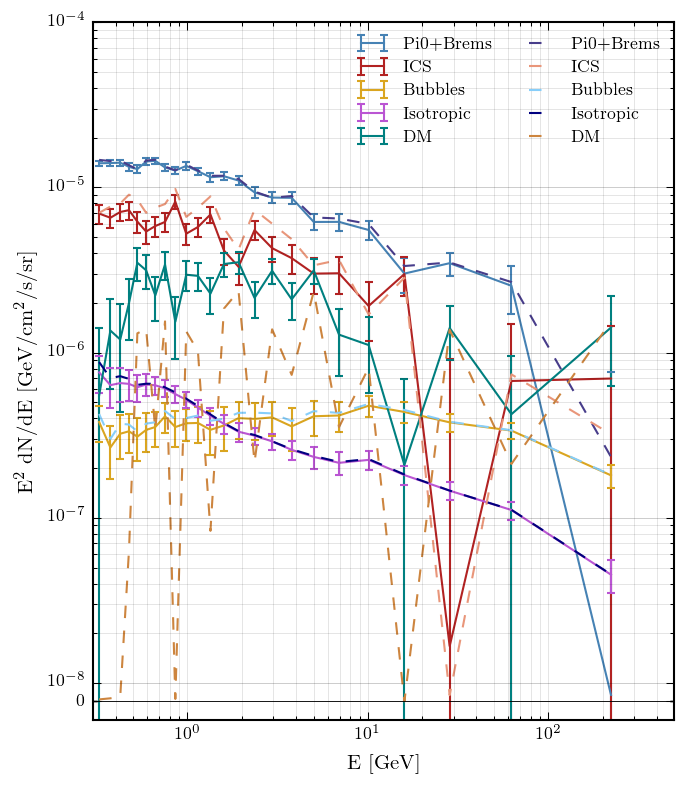

In [34]:
import Template
import Tools, healpy
reload(Tools)


#print np.array(A.m.matrix()).shape

#print A.templateList['DM'].valueError/A.templateList['DM'].value


plt.figure(figsize=(5,6))
def PlotComponent(A, name,ls='-'):
    E, flux, stat = A.GetSpectrum(name)
    #if stat
    
    if ls=='-':
        yerr = E**2*stat.T/1e3
    else:
        yerr=None
    
    if name is 'Data':
        plt.errorbar(E/1e3,E**2*flux/1e3,E**2*stat.T/1e3, label=name.replace('_','+'),
                     capthick=1, capsize=2, ls='-',c='k')    
    else:
        plt.errorbar(E/1e3,E**2*flux/1e3, yerr=yerr, label=name.replace('_','+'),capthick=1, capsize=2, ls=ls )
        
        
        
    
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
    plt.xlabel(r'$\rm{E\ [GeV]}$')
    plt.grid(which='both', alpha=.1, linestyle='-')
    
#PlotComponent(A,'Data')    
#PlotComponent(A,'PSC')
PlotComponent(A,'Pi0_Brems')
#PlotComponent('Brems')
PlotComponent(A,'ICS')
PlotComponent(A,'Bubbles')
PlotComponent(A,'Isotropic')
PlotComponent(A,'DM')
#PlotComponent(A2,'DM')

PlotComponent(A2,'Pi0_Brems',ls='--')
PlotComponent(A2,'ICS',ls='--')
PlotComponent(A2,'Bubbles',ls='--')
PlotComponent(A2,'Isotropic',ls='--')
PlotComponent(A2,'DM',ls='--')


# print np.sum(A.loglike)
# print np.sum(A2.loglike)

linthresh=1e-8
plt.yscale('symlog', linthreshy=linthresh, subsy=np.arange(0,10),linscaley=0.1)
plt.ylim(-1e-8,1e-4)

plt.legend(frameon=False, fontsize=8,ncol=2)
#plt.ylim(1e-8,4e-4)
plt.xlim(.3,500)

#A.SaveSpectra('./mod_c/spec_mod_s_42_P8_GC_free_brems.pickle') # 3FGL with ext XCO fitted 
#A.SaveSpectra('./mod_c/spec_mod_s_44_P8_GC_free_brems.pickle') # 3FGL with ext XCO fitted 
#A.SaveSpectra('./mod_c/spec_mod_s_46_P8_GC.pickle') # 3FGL with ext XCO fitted 


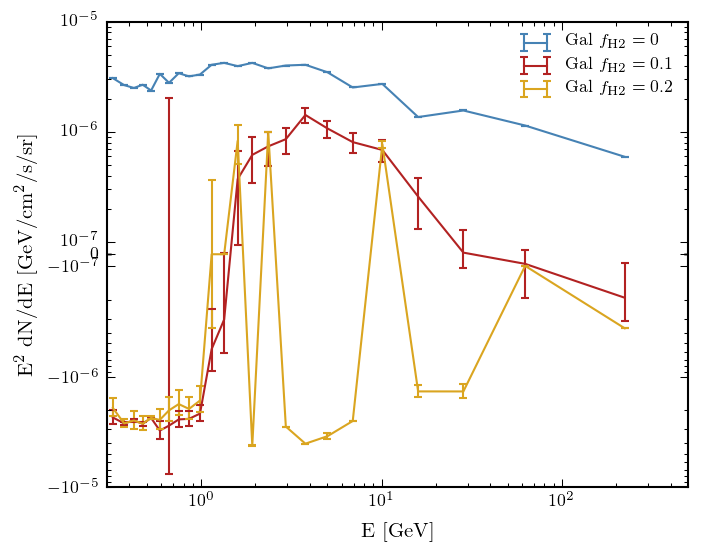

In [61]:
import pickle

plt.figure(figsize=(5,4))
def PlotComponentFromFile(name, filename,label='', linestyle='-'):
    E, flux, stat = pickle.load(open(filename))[name] # A.GetSpectrum(name)
    #if stat
    if name is 'Data':
        plt.errorbar(E/1e3,E**2*flux/1e3,E**2*stat.T/1e3, label=label,
                     capthick=1, capsize=2, ls='-',c='k')
    else:
        plt.errorbar(E/1e3,E**2*flux/1e3,E**2*stat.T/1e3, label=label,capthick=1, capsize=2, ls=linestyle )
    
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
    plt.xlabel(r'$\rm{E\ [GeV]}$')

    
    
PlotComponentFromFile('DM','./mod_c/spec_mod_s_42_P8_GC.pickle', label=r'Gal $f_{\rm H2}=0$ ', linestyle='-')
PlotComponentFromFile('DM','./mod_c/spec_mod_s_44_P8_GC.pickle', label=r'Gal $f_{\rm H2}=0.1$ ', linestyle='-')
PlotComponentFromFile('DM','./mod_c/spec_mod_s_46_P8_GC.pickle', label=r'Gal $f_{\rm H2}=0.2$ ', linestyle='-')




linthresh=1e-7
plt.yscale('symlog', linthreshy=linthresh, subsy=np.arange(0,10),linscaley=0.1)
plt.ylim(-1e-5,1e-5)
#plt.ylim(5e-8,2e-6)

plt.legend(frameon=False, fontsize=8,ncol=1)

plt.xlim(.3,500)

plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/20x20_ROI.pdf',bbox_inches='tight')


In [6]:
h = h5py.File('/data/GCE_sys/new/mod_s_46_XCO_P8.hdf5')
for f in h:
    print f

fit_results
galdef
templates


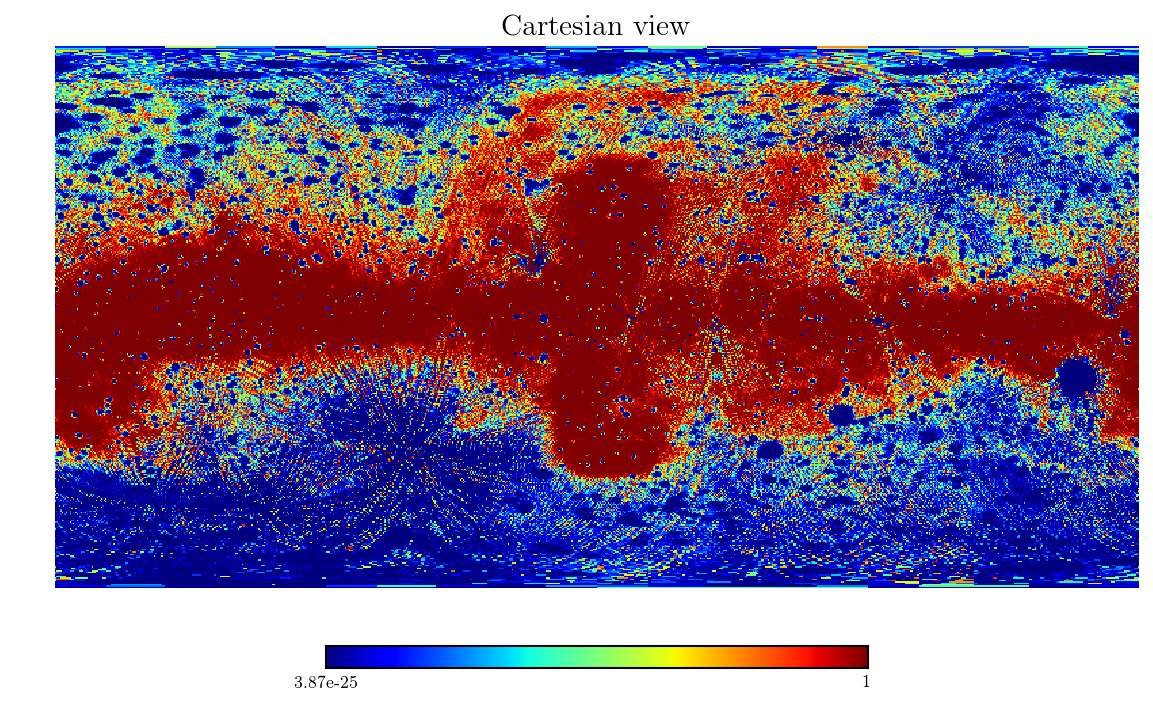

In [9]:
import healpy
healpy.cartview(A.psc_weights[22])

In [ ]:
def AddFermiBubbleTemplate(self, template_file='./bubble_templates_diskcut30.0.fits',
                               spec_file='./reduced_bubble_spec_apj_793_64.dat', fixSpectrum=False, fixNorm=False):
        """
        Adds a fermi bubble template to the template stack.

        :param template_file: Requires file 'bubble_templates_diskcut30.0.fits'
            style file (from Su & Finkbeiner) with an extension table with a NAME column containing "Whole bubble"
            and a TEMPLATE column with an order 8 healpix array.
        :param spec_file: filename containing three columns (no header).  First col is energy in MeV, second is
            dN/dE in units (s cm^2 sr MeV)^-1 third is the uncertainty in dN/dE in (s cm^2 sr MeV)^-1.
        :param fixSpectrum: If True, the spectrum is not allowed to float.
        """

        # Load the template and spectrum
        hdu = pyfits.open(template_file)
        bub_idx = np.where(hdu[1].data['NAME'] == 'Whole bubble')
        bubble = hdu[1].data['TEMPLATE'][bub_idx][0]

        # Resize template if need be.
        nside_in = int(np.sqrt(bubble.shape[0]/12))
        if nside_in != self.nside:
            bubble = Tools.ResizeHealpix(bubble, self.nside, average=True)

        energy, dnde, dnde_unc = np.genfromtxt(spec_file).T
        spec = lambda e: np.interp(e, energy, dnde)
        spec_unc = lambda e: np.interp(e, energy, dnde_unc)

        # Get lat/lon for each pixel
        l,b = Tools.hpix2ang(np.arange(12*self.nside**2))

        healpixcube = np.zeros(shape=(self.n_bins, 12*self.nside**2))
        valueUnc = []
        for i_E in range(self.n_bins):
            # Determine the counts in each bin.
            e1, e2 = self.bin_edges[i_E], self.bin_edges[i_E+1]
            # integrate spectrum over energy band
            flux = quad(spec, e1, e2)[0]
            flux_unc = quad(spec_unc, e1, e2)[0]

            if flux != 0:
                val_unc = flux_unc/flux  # fractional change allowed in value
            else:
                val_unc = 1e20  # if the flux is zero, just make this bin unimportant by setting the error barto inf.
            valueUnc.append(val_unc)

            # Multiply mask by counts.
            healpixcube[i_E] = bubble*flux*(healpy.nside2pixarea(self.nside))

        # Now each bin is in ph cm^-2 s^-1.  Apply IRF takes care of the rest.
        self.AddTemplate(healpixCube=healpixcube, name='Bubbles', fixSpectrum=fixSpectrum,
                         fixNorm=fixNorm, limits=[None, None], value=1., ApplyIRF=True,
                         sourceClass='GEN', valueUnc=valueUnc)
        
        
AddFermiBubbleTemplate(A)




In [77]:
#psc_mask = np.load('./cartesian_psc_mask_15x15.npy')
psc_mask = np.load('./cartesian_psc_mask_PSF3_15x15.npy')
psc_mask[psc_mask<0.5]=0
psc_mask[psc_mask>0.5]=1

# mask the plane
psc_mask[:,110:190,:] =0 

print psc_mask.shape
print list(np.sum(np.sum(psc_mask*0.05**2,axis=1), axis=1) * (np.pi/180.**2))


psf_all = np.array([2.4240683e-07, 6.9570757e-05, 0.00044627098, 0.0011904598, 0.0029508176, 0.0053137974, 0.0070710033, 0.0085555008, 0.0098678907, 0.010777159, 0.011653216, 0.012780407, 0.013427874, 0.013922142, 0.014293026, 0.014626577, 0.014863407, 0.014980731, 0.015175141, 0.015240834, 0.015324708, 0.015419003, 0.01547209, 0.015547721, 0.015574386, 0.015603233, 0.01563232, 0.015643712, 0.015635232, 0.015640322, 0.015632562, 0.015632562, 0.015628442, 0.015611474])
print np.sum(np.sum(psc_mask*0.05**2,axis=1), axis=1) * (np.pi/180.**2)/psf_all

(34, 300, 300)
[0.00022228705, 0.0014471685, 0.0041376404, 0.006090953, 0.0077693774, 0.0091341259, 0.010163142, 0.011103195, 0.012059004, 0.012740409, 0.013392969, 0.014058132, 0.014442346, 0.014775898, 0.014996246, 0.015143386, 0.015281316, 0.015389428, 0.015481059, 0.015566386, 0.015651472, 0.01574116, 0.015827943, 0.01583764, 0.015852911, 0.015863819, 0.015868668, 0.015868668, 0.015868668, 0.015868668, 0.015868668, 0.015868668, 0.015874, 0.015874]
[ 916.99996025   20.80139114    9.27158731    5.11647098    2.63295754
    1.71894508    1.43729849    1.29778436    1.22204475    1.18216768
    1.14929381    1.09997528    1.07554972    1.06132363    1.04920018
    1.03533356    1.02811663    1.02728154    1.02015918    1.02136053
    1.02132268    1.02089351    1.02299965    1.01864701    1.01788356
    1.01670077    1.01511916    1.01437993    1.0149301     1.0145998
    1.01510344    1.01510344    1.01571227    1.01681624]


In [47]:
print 9.5/.05

190.0


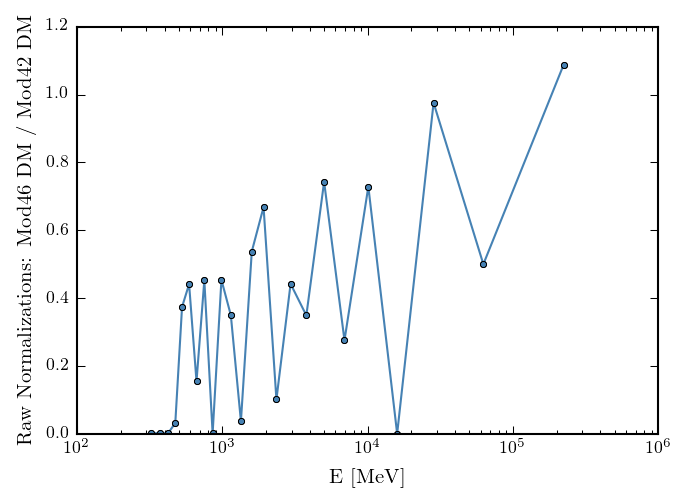

In [75]:
a = np.average(A2.templateList['DM'].valueError, axis=1)
b = np.average(A.templateList['DM'].valueError, axis=1)


plt.ylabel('Raw Normalizations: Mod46 DM / Mod42 DM')
plt.xlabel('E [MeV]')
plt.errorbar(A.central_energies, A2.templateList['DM'].value/A.templateList['DM'].value,marker='o', markersize=3)# np.sqrt(a**2/b**4*b**2 + 1/b**2*a**2))
plt.xscale('log')
